### Import the dependencies

In [1]:
%load_ext lab_black

# Common Imports
import numpy as np
import pandas as pd

# Preprocessing
from scipy.stats import norm

# Assessing performance
from sklearn.metrics import mean_squared_error

from scipy.stats import multivariate_normal

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Fine Tuning
from sklearn.model_selection import GridSearchCV

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

# To make this notebook's output identical at every run
np.random.seed(42)

### Inspect the data

In [2]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1 (deal with this later!)
    .query("marker % 2 == 0")
    .drop(["z", "anchors"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "time",
    "tag",
    "x",
    "y",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data = data.loc[:, ["position", "tag", "x", "y"]]
data

,position,tag,x,y
0,1,1,1595,1916
1,1,2,1614,1989
2,1,3,1620,1971
3,1,1,1595,1915
4,1,2,1614,1988
...,...,...,...,...
27655,11,2,1315,1863
27656,11,3,1345,1886
27657,11,1,1313,1899
27658,11,2,1315,1861


#### Look at the noise at each of the different locations

In [ ]:
ax = plt.gca()
ax.invert_yaxis()
ax.scatter(
    data.query("tag == 1").x, data.query("tag == 1").y, label="tag_1", color="C0"
)
ax.scatter(
    data.query("tag == 2").x, data.query("tag == 2").y, label="tag_2", color="C1"
)
ax.scatter(
    data.query("tag == 3").x, data.query("tag == 3").y, label="tag_3", color="C2"
)

plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("1.png", transparent=True)
plt.show()

#### Look at the noise in each tag at each of the different locations

In [ ]:
for i in data["position"].unique():
    tag_1_x = data.query(f"position == {i} & tag == 1").x.reset_index(drop=True)
    tag_2_x = data.query(f"position == {i} & tag == 2").x.reset_index(drop=True)
    tag_3_x = data.query(f"position == {i} & tag == 3").x.reset_index(drop=True)

    tag_1_y = data.query(f"position == {i} & tag == 1").y.reset_index(drop=True)
    tag_2_y = data.query(f"position == {i} & tag == 2").y.reset_index(drop=True)
    tag_3_y = data.query(f"position == {i} & tag == 3").y.reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(tag_1_x, label="tag_1", color="C0")
    axes[0].plot(tag_2_x, label="tag_2", color="C1")
    axes[0].plot(tag_3_x, label="tag_3", color="C2")
    axes[0].legend(loc="lower right")
    axes[0].title.set_text(f"position {i} - x")

    axes[1].plot(tag_1_y, label="tag_1", color="C0")
    axes[1].plot(tag_2_y, label="tag_2", color="C1")
    axes[1].plot(tag_3_y, label="tag_3", color="C2")
    axes[1].legend(loc="lower right")
    axes[1].title.set_text(f"position {i} - y")

    fig.tight_layout()
    fig.show()

#### Plot the histogram and the PDF for each tag and each position 

In [ ]:
for i in sorted(data["position"].unique()):

    for j in ["x", "y"]:

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

        tag_1 = data.query(f"position == {i} & tag == 1")[j]
        tag_2 = data.query(f"position == {i} & tag == 2")[j]
        tag_3 = data.query(f"position == {i} & tag == 3")[j]

        # Fit a normal distribution to the data:
        mu_1, std_1 = norm.fit(tag_1)
        mu_2, std_2 = norm.fit(tag_2)
        mu_3, std_3 = norm.fit(tag_3)

        # Plot the histogram.
        axes[0].hist(tag_1, bins=25, density=True, color="C0")
        axes[1].hist(tag_2, bins=25, density=True, color="C1")
        axes[2].hist(tag_3, bins=25, density=True, color="C2")

        # Plot the PDF.
        xmin, xmax = axes[0].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_1, std_1)
        axes[0].plot(x, p, "k", linewidth=2)
        title = "Position %d - tag 1 - %s \n mu = %.2f,  std = %.2f" % (
            i,
            j,
            mu_1,
            std_1,
        )
        axes[0].title.set_text(title)

        # Plot the PDF.
        xmin, xmax = axes[1].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_2, std_2)
        axes[1].plot(x, p, "k", linewidth=2)
        title = "Position %d - tag 2 - %s \n mu = %.2f,  std = %.2f" % (
            i,
            j,
            mu_2,
            std_2,
        )
        axes[1].title.set_text(title)

        # Plot the PDF.
        xmin, xmax = axes[2].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_3, std_3)
        axes[2].plot(x, p, "k", linewidth=2)
        title = "Position %d - tag 3 - %s \n mu = %.2f,  std = %.2f" % (
            i,
            j,
            mu_3,
            std_3,
        )
        axes[2].title.set_text(title)

        fig.tight_layout()
        fig.show()

***

### Baseline - Using a Single Tag

In [3]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

for i in sorted(data["position"].unique()):
    dist_err = []

    tag_1 = data.query(f"position == {i} & tag == 1")
    tag_2 = data.query(f"position == {i} & tag == 2")
    tag_3 = data.query(f"position == {i} & tag == 3")

    x_avg_actual, y_avg_actual = next(true_pos)

    print("-" * 76)
    print(f"Position {i}:")
    print("-" * 76)
    print("Actual:", (x_avg_actual, y_avg_actual))

    for i, tag in enumerate([tag_1, tag_2, tag_3]):
        x_calc = int(tag.x.mean())
        y_calc = int(tag.y.mean())

        distance = (
            ((x_calc - x_avg_actual) ** 2) + ((y_calc - y_avg_actual) ** 2)
        ) ** 0.5

        print()
        print(f"Tag {i+1}: ", (x_calc, y_calc))
        print("Distance:", distance)

        dist_err.append(distance)

    print(f"\nThe error range lies between {min(dist_err)} cm and {max(dist_err)} cm.")

----------------------------------------------------------------------------
Position 1:
----------------------------------------------------------------------------
Actual: (1597, 1958)

Tag 1:  (1593, 1912)
Distance: 46.17358552246078

Tag 2:  (1614, 1994)
Distance: 39.81205847478876

Tag 3:  (1624, 1973)
Distance: 30.886890422961002

The error range lies between 30.886890422961002 cm and 46.17358552246078 cm.
----------------------------------------------------------------------------
Position 2:
----------------------------------------------------------------------------
Actual: (766, 1690)

Tag 1:  (750, 1658)
Distance: 35.77708763999664

Tag 2:  (736, 1636)
Distance: 61.773780845922005

Tag 3:  (753, 1653)
Distance: 39.21734310225516

The error range lies between 35.77708763999664 cm and 61.773780845922005 cm.
----------------------------------------------------------------------------
Position 3:
----------------------------------------------------------------------------
Actual

***

### Method 1: Leverage Multi-tag Readings and Average over each tag

In [4]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

for i in sorted(data["position"].unique()):
    tag_1 = data.query(f"position == {i} & tag == 1")
    tag_2 = data.query(f"position == {i} & tag == 2")
    tag_3 = data.query(f"position == {i} & tag == 3")

    x_avg_calc = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg_calc = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    x_avg_actual, y_avg_actual = next(true_pos)

    distance = (
        ((x_avg_calc - x_avg_actual) ** 2) + ((y_avg_calc - y_avg_actual) ** 2)
    ) ** 0.5

    print("-" * 76)
    print(f"Position {i}:")
    print("-" * 76)
    print("Actual:", (x_avg_actual, y_avg_actual))
    print("\nCalc:  ", (x_avg_calc, y_avg_calc))
    print("Distance:", distance)

----------------------------------------------------------------------------
Position 1:
----------------------------------------------------------------------------
Actual: (1597, 1958)

Calc:   (1610, 1959)
Distance: 13.038404810405298
----------------------------------------------------------------------------
Position 2:
----------------------------------------------------------------------------
Actual: (766, 1690)

Calc:   (746, 1649)
Distance: 45.617978911828175
----------------------------------------------------------------------------
Position 3:
----------------------------------------------------------------------------
Actual: (530, 2040)

Calc:   (535, 2097)
Distance: 57.21887800367987
----------------------------------------------------------------------------
Position 4:
----------------------------------------------------------------------------
Actual: (839, 2244)

Calc:   (813, 2250)
Distance: 26.68332812825267
--------------------------------------------------------

***

### Method 2: Filter out Noise using Data that follows the Expected Constraint

For a given reading, compute the distance from tag 1 to tag 2, tag 2 to tag 3, and tag 1 to tag 3

$d(tag_1,tag_2) = \sqrt{(tag_{2_x} - tag_{1_x})^2 + (tag_{2_y} - tag_{1_y})^2}$

$d(tag_2,tag_3) = \sqrt{(tag_{3_x} - tag_{2_x})^2 + (tag_{3_y} - tag_{2_y})^2}$

$d(tag_1,tag_3) = \sqrt{(tag_{3_x} - tag_{1_x})^2 + (tag_{3_y} - tag_{1_y})^2}$

In [5]:
data_tag_1 = data.query("tag == 1").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_2 = data.query("tag == 2").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_3 = data.query("tag == 3").loc[:, ["x", "y"]].copy().reset_index(drop=True)

In [6]:
AB = data_tag_1.sub(data_tag_2).pow(2).sum(axis=1).pow(0.5)
BC = data_tag_2.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)
AC = data_tag_1.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)

In [7]:
distances = pd.DataFrame(
    data=[AB, BC, AC], index=["tag_1_to_tag_2", "tag_2_to_tag_3", "tag_1_to_tag_3"]
).T

true_mean = 21.59
calc_mean_distances = distances.to_numpy().mean()
std_distances = distances.to_numpy().std()

distances

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
0,75.432089,18.973666,60.415230
1,75.432089,17.888544,63.071388
2,85.375641,25.298221,65.306967
3,84.403791,23.769729,64.474801
4,88.526832,34.132096,57.271284
...,...,...,...
9215,40.000000,39.824616,34.438351
9216,38.052595,35.805028,35.355339
9217,37.054015,34.409301,34.481879
9218,37.054015,37.802116,34.928498


In [8]:
calc_mean_distances, std_distances

(51.965722316201536, 28.96962034612344)

In [9]:
lower_bnd = true_mean - std_distances if true_mean - std_distances > 0 else 0
upper_bnd = true_mean + std_distances

lower_bnd, upper_bnd

(0, 50.55962034612344)

In [10]:
distances.describe().T

,count,mean,std,min,25%,50%,75%,max
tag_1_to_tag_2,9220.0,61.808037,33.522837,6.403124,34.205263,61.983869,80.112421,173.487752
tag_2_to_tag_3,9220.0,44.071446,21.538321,2.236068,24.083189,42.426407,55.585518,102.156742
tag_1_to_tag_3,9220.0,50.017684,27.700300,0.000000,34.928498,48.979549,70.342022,125.143917


In [11]:
position = data.query("tag == 1").loc[:, ["position"]].copy().reset_index(drop=True)

distances = position.join(distances)
distances

,position,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
0,1,75.432089,18.973666,60.415230
1,1,75.432089,17.888544,63.071388
2,1,85.375641,25.298221,65.306967
3,1,84.403791,23.769729,64.474801
4,1,88.526832,34.132096,57.271284
...,...,...,...,...
9215,11,40.000000,39.824616,34.438351
9216,11,38.052595,35.805028,35.355339
9217,11,37.054015,34.409301,34.481879
9218,11,37.054015,37.802116,34.928498


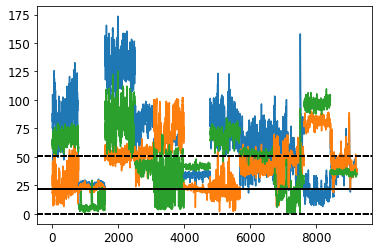

In [12]:
for i in sorted(data["position"].unique()):
    ax = plt.gca()

    ax.plot(
        distances.query(f"position == {i}").loc[:, ["tag_1_to_tag_2"]], color="C0",
    )

    ax.plot(
        distances.query(f"position == {i}").loc[:, ["tag_2_to_tag_3"]], color="C1",
    )

    ax.plot(
        distances.query(f"position == {i}").loc[:, ["tag_1_to_tag_3"]], color="C2",
    )

    ax.axhline(y=lower_bnd, color="black", linestyle="dashed")
    ax.axhline(y=true_mean, color="black", linestyle="solid")
    ax.axhline(y=upper_bnd, color="black", linestyle="dashed")

### Pick the two best ones

In [16]:
def temp(df_orig):
    df = df_orig.copy()

    for i, row in df.iterrows():
        keep_1, keep_2 = df.loc[i, "keep"]
        df.loc[i, keep_1] = True
        df.loc[i, keep_2] = True

    return df


keep = (
    distances.drop("position", axis=1)
    .sub(true_mean)
    .apply(abs)
    .idxmin(axis=1)
    .apply(lambda x: x.split("_to_"))
    .to_frame(name="keep")
    .assign(position=position, tag_1=False, tag_2=False, tag_3=False)
    .pipe(temp)
    .drop("keep", axis=1)
)


tag_1_filt = data_tag_1.assign(tag_1=keep["tag_1"], position=position).query(
    "tag_1 == True"
)


tag_2_filt = data_tag_2.assign(tag_2=keep["tag_2"], position=position).query(
    "tag_2 == True"
)


tag_3_filt = data_tag_3.assign(tag_3=keep["tag_3"], position=position).query(
    "tag_3 == True"
)

In [17]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

for i in sorted(data["position"].unique()):
    tag_1 = tag_1_filt.query(f"position == {i}")
    tag_2 = tag_2_filt.query(f"position == {i}")    
    tag_3 = tag_3_filt.query(f"position == {i}")

    x_avg_calc = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg_calc = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    x_avg_actual, y_avg_actual = next(true_pos)

    distance = (
        ((x_avg_calc - x_avg_actual) ** 2) + ((y_avg_calc - y_avg_actual) ** 2)
    ) ** 0.5

    print(f"Position {i}:")
    print("Actual:", (x_avg_actual, y_avg_actual))
    print("Calc:  ", (x_avg_calc, y_avg_calc))
    print("Distance:", distance)
    print("-" * 28)

1595.0588235294117 1918.1764705882354
1614.320659062104 1993.974651457541
1624.4430379746836 1973.059493670886
Position 1:
Actual: (1597, 1958)
Calc:   (1611, 1961)
Distance: 14.317821063276353
----------------------------
742.3194444444445 1658.6666666666667
736.308564231738 1636.9609571788412
753.0794520547945 1653.468493150685
Position 2:
Actual: (766, 1690)
Calc:   (743, 1649)
Distance: 47.01063709417264
----------------------------
527.2352941176471 2154.705882352941
548.0783874580068 2038.407614781635
528.276923076923 2085.854945054945
Position 3:
Actual: (530, 2040)
Calc:   (534, 2092)
Distance: 52.15361924162119
----------------------------
848.2721088435375 2271.6643990929706
784.5238095238095 2245.0396825396824
821.5873015873016 2239.2345679012346
Position 4:
Actual: (839, 2244)
Calc:   (818, 2251)
Distance: 22.135943621178654
----------------------------
1311.349889624724 1703.2483443708609
1248.8666666666666 1715.1333333333334
1318.1376248612653 1721.2708102108768
Position 

ValueError: cannot convert float NaN to integer

In [21]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

for i in sorted(data["position"].unique()):
    dist_err = []

    tag_1 = tag_1_filt.query(f"position == {i}")
    tag_2 = tag_2_filt.query(f"position == {i}")    
    tag_3 = tag_3_filt.query(f"position == {i}")

    x_avg_actual, y_avg_actual = next(true_pos)

    print("-" * 76)
    print(f"Position {i}:")
    print("-" * 76)
    print("Actual:", (x_avg_actual, y_avg_actual))

    for i, tag in enumerate([tag_1, tag_2, tag_3]):
        x_calc = int(tag.x.mean())
        y_calc = int(tag.y.mean())

        distance = (
            ((x_calc - x_avg_actual) ** 2) + ((y_calc - y_avg_actual) ** 2)
        ) ** 0.5

        print()
        print(f"Tag {i+1}: ", (x_calc, y_calc))
        print("Distance:", distance)

        dist_err.append(distance)

    print(f"\nThe error range lies between {min(dist_err)} cm and {max(dist_err)} cm")

----------------------------------------------------------------------------
Position 1:
----------------------------------------------------------------------------
Actual: (1597, 1958)

Tag 1:  (1595, 1918)
Distance: 40.049968789001575

Tag 2:  (1614, 1993)
Distance: 38.91015291668744

Tag 3:  (1624, 1973)
Distance: 30.886890422961002

The error range lies between 30.886890422961002 cm and 40.049968789001575 cm
----------------------------------------------------------------------------
Position 2:
----------------------------------------------------------------------------
Actual: (766, 1690)

Tag 1:  (742, 1658)
Distance: 40.0

Tag 2:  (736, 1636)
Distance: 61.773780845922005

Tag 3:  (753, 1653)
Distance: 39.21734310225516

The error range lies between 39.21734310225516 cm and 61.773780845922005 cm
----------------------------------------------------------------------------
Position 3:
----------------------------------------------------------------------------
Actual: (530, 2040)

ValueError: cannot convert float NaN to integer

In [ ]:
bounded = (distances >= lower_bnd) & (distances <= upper_bnd)
bounded = bounded.drop("position", axis=1)

# leave these alone
bounded_all_three = bounded[(bounded.sum(axis=1) == 3)]

# replace the odd one with the average of the other two
bounded_only_two = bounded[(bounded.sum(axis=1) == 2)]
bounded_only_one = ~bounded[(bounded.sum(axis=1) == 1)]
# for simplicity, convert two false into trues
bounded[(bounded.sum(axis=1) == 1)] = ~bounded[(bounded.sum(axis=1) == 1)]

# drop these
bounded_none = bounded[(bounded.sum(axis=1) == 0)]

In [ ]:
tag_1_drop = data_tag_1.assign(keep=bounded["tag_1_to_tag_2"], position=position)
tag_2_drop = data_tag_2.assign(keep=bounded["tag_2_to_tag_3"], position=position)
tag_3_drop = data_tag_3.assign(keep=bounded["tag_1_to_tag_3"], position=position)

tag_1_drop = tag_1_drop[tag_1_drop["keep"]]
tag_2_drop = tag_2_drop[tag_2_drop["keep"]]
tag_3_drop = tag_3_drop[tag_3_drop["keep"]]

In [ ]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)
list(true_pos)

In [ ]:
pos_1 = tag_1_drop.query("position == 1")
pos_1.x.mean(), pos_1.y.mean()

In [ ]:
pos_2 = tag_2_drop.query("position == 1")
pos_2.x.mean(), pos_2.y.mean()

In [ ]:
pos_3 = tag_3_drop.query("position == 1")
pos_3.x.mean(), pos_3.y.mean()

In [ ]:
(pos_1.x.mean() + pos_2.x.mean() + pos_3.x.mean()) / 3

In [ ]:
# for i in data["position"].unique():
#     tag_1_x = tag_1_drop.query(f"position == {i}").x.reset_index(drop=True)
#     tag_2_x = tag_2_drop.query(f"position == {i}").x.reset_index(drop=True)
#     tag_3_x = tag_3_drop.query(f"position == {i}").x.reset_index(drop=True)

#     tag_1_y = tag_1_drop.query(f"position == {i}").y.reset_index(drop=True)
#     tag_2_y = tag_2_drop.query(f"position == {i}").y.reset_index(drop=True)
#     tag_3_y = tag_3_drop.query(f"position == {i}").y.reset_index(drop=True)

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

#     axes[0].plot(tag_1_x, label="tag_1", color="C0")
#     axes[0].plot(tag_2_x, label="tag_2", color="C1")
#     axes[0].plot(tag_3_x, label="tag_3", color="C2")
#     axes[0].legend(loc="lower right")
#     axes[0].title.set_text(f"position {i} - x")

#     axes[1].plot(tag_1_y, label="tag_1", color="C0")
#     axes[1].plot(tag_2_y, label="tag_2", color="C1")
#     axes[1].plot(tag_3_y, label="tag_3", color="C2")
#     axes[1].legend(loc="lower right")
#     axes[1].title.set_text(f"position {i} - y")

#     fig.tight_layout()
#     fig.show()

In [ ]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

for i in sorted(data["position"].unique()):
    tag_1 = tag_1_drop.query(f"position == {i}")
    tag_2 = tag_2_drop.query(f"position == {i}")
    tag_3 = tag_3_drop.query(f"position == {i}")

    x_avg_calc = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg_calc = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    x_avg_actual, y_avg_actual = next(true_pos)

    distance = (
        ((x_avg_calc - x_avg_actual) ** 2) + ((y_avg_calc - y_avg_actual) ** 2)
    ) ** 0.5

    print(f"Position {i}:")
    print("Actual:", (x_avg_actual, y_avg_actual))
    print("Calc:  ", (x_avg_calc, y_avg_calc))
    print("Distance:", distance)
    print("-" * 28)

### Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

for i in sorted(data["position"].unique()):
    
    lof = LocalOutlierFactor()

    tag_1 = data.query(f"position == {i} & tag == 1").loc[:, ["x", "y"]]
    tag_2 = data.query(f"position == {i} & tag == 2").loc[:, ["x", "y"]]
    tag_3 = data.query(f"position == {i} & tag == 3").loc[:, ["x", "y"]]

    print(f"Position {i}:")

    tag_1_lof = lof.fit_predict(tag_1.to_numpy())
    tag_1_clean = tag_1[tag_1_lof != -1]
    print(
        "Tag 1:",
        len(tag_1),
        "-",
        len(tag_1_clean),
        "=",
        len(tag_1) - len(tag_1_clean),
        "outliers",
    )

    tag_2_lof = lof.fit_predict(tag_2.to_numpy())
    tag_2_clean = tag_2[tag_2_lof != -1]
    print(
        "Tag 2:",
        len(tag_2),
        "-",
        len(tag_2_clean),
        "=",
        len(tag_2) - len(tag_2_clean),
        "outliers",
    )

    tag_3_lof = lof.fit_predict(tag_3.to_numpy())
    tag_3_clean = tag_3[tag_3_lof != -1]
    print(
        "Tag 3:",
        len(tag_3),
        "-",
        len(tag_3_clean),
        "=",
        len(tag_3) - len(tag_3_clean),
        "outliers",
    )

    print("-" * 32)

In [ ]:
for i in sorted(data["position"].unique()):
    lof = LocalOutlierFactor()

    tag_1 = data.query(f"position == {i} & tag == 1").loc[:, ["x", "y"]]
    tag_2 = data.query(f"position == {i} & tag == 2").loc[:, ["x", "y"]]
    tag_3 = data.query(f"position == {i} & tag == 3").loc[:, ["x", "y"]]

    tag_1_lof = lof.fit_predict(tag_1.to_numpy())
    tag_1_clean = tag_1[tag_1_lof != -1]

    tag_2_lof = lof.fit_predict(tag_2.to_numpy())
    tag_2_clean = tag_2[tag_2_lof != -1]

    tag_3_lof = lof.fit_predict(tag_3.to_numpy())
    tag_3_clean = tag_3[tag_3_lof != -1]

    for j in ["x", "y"]:

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

        tag_1 = tag_1_clean[j]
        tag_2 = tag_2_clean[j]
        tag_3 = tag_3_clean[j]

        # Fit a normal distribution to the data:
        mu_1, std_1 = norm.fit(tag_1)
        mu_2, std_2 = norm.fit(tag_2)
        mu_3, std_3 = norm.fit(tag_3)

        avg_mu = (mu_1 + mu_2 + mu_3) // 3

        print("Position", j, avg_mu)

        # Plot the histogram.
        axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
        axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
        axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

        # Plot the PDF.
        xmin, xmax = axes[0].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_1, std_1)
        axes[0].plot(x, p, "k", linewidth=2)
        title = "Position %d - tag 1 - %s \n mu = %.2f,  std = %.2f" % (
            i,
            j,
            mu_1,
            std_1,
        )
        axes[0].title.set_text(title)

        # Plot the PDF.
        xmin, xmax = axes[1].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_2, std_2)
        axes[1].plot(x, p, "k", linewidth=2)
        title = "Position %d - tag 2 - %s \n mu = %.2f,  std = %.2f" % (
            i,
            j,
            mu_2,
            std_2,
        )
        axes[1].title.set_text(title)

        # Plot the PDF.
        xmin, xmax = axes[2].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_3, std_3)
        axes[2].plot(x, p, "k", linewidth=2)
        title = "Position %d - tag 3 - %s \n mu = %.2f,  std = %.2f" % (
            i,
            j,
            mu_3,
            std_3,
        )
        axes[2].title.set_text(title)

        fig.tight_layout()
        fig.show()